In [6]:
import tensorflow as tf
from keras.datasets import mnist
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Bidirectional,SimpleRNN
import os
import seaborn as sns
from sklearn import metrics
from timeit import default_timer as timer

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  


In [7]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train/255.0
x_test = x_test/255.0

In [8]:
f1 = []
log_loss = []  
accuracy = []
class PredictionCallback(tf.keras.callbacks.Callback):    
  def on_epoch_end(self, epoch, logs={}):
    y_pred = self.model.predict(x_test)
    index = []
    for array in y_pred:
        for i in range(len(array)):
            if max(array, key=lambda x: x) == array[i]:
                index.append(i)

    # Evaluate the model on training and testing data
    f1.append(metrics.f1_score(y_test, index , average='macro'))
    log_loss.append((metrics.log_loss(y_test, y_pred)))
    accuracy.append(metrics.balanced_accuracy_score(y_test, index))

In [9]:
class Model_Timer(tf.keras.callbacks.Callback):
    def __init__(self):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

In [10]:
model = Sequential([
    Bidirectional(SimpleRNN(50,return_sequences=True)),
    Bidirectional(SimpleRNN(50, return_sequences=True)),
    Bidirectional(SimpleRNN(50, return_sequences=True)),
    Bidirectional(SimpleRNN(50)),
    Dense(10,activation="softmax")
])
cb = Model_Timer()
# Compile the model
model.compile(optimizer=tf.optimizers.legacy.Adam(learning_rate=0.001), loss="sparse_categorical_crossentropy", metrics=["MeanAbsoluteError","RootMeanSquaredError", "MeanSquaredError"])
model.fit(x_train, y_train, batch_size=8, epochs=10, validation_data=(x_test, y_test),callbacks=[PredictionCallback(), cb])

Epoch 1/10
7500/7500 [==============================] - 110s 14ms/step - loss: 0.3306 - mean_absolute_error: 4.3739 - root_mean_squared_error: 5.2325 - mean_squared_error: 27.3786 - val_loss: 0.2136 - val_mean_absolute_error: 4.3630 - val_root_mean_squared_error: 5.2278 - val_mean_squared_error: 27.3304
Epoch 2/10
7500/7500 [==============================] - 166s 22ms/step - loss: 0.2283 - mean_absolute_error: 4.3739 - root_mean_squared_error: 5.2330 - mean_squared_error: 27.3846 - val_loss: 0.2068 - val_mean_absolute_error: 4.3630 - val_root_mean_squared_error: 5.2281 - val_mean_squared_error: 27.3327
Epoch 3/10
7500/7500 [==============================] - 164s 22ms/step - loss: 0.2142 - mean_absolute_error: 4.3739 - root_mean_squared_error: 5.2331 - mean_squared_error: 27.3851 - val_loss: 0.2153 - val_mean_absolute_error: 4.3630 - val_root_mean_squared_error: 5.2279 - val_mean_squared_error: 27.3306
Epoch 4/10
7500/7500 [==============================] - 162s 22ms/step - loss: 0.2160

In [11]:
time_took_to_run = sum(cb.logs)
time_took_to_run

1589.7274810841773

In [17]:
y_pred = model.predict(x_test)
index = []
for array in y_pred:
    for i in range(len(array)):
        if max(array, key=lambda x: x) == array[i]:
            index.append(i)

print("Accuracy (validation): " + str(metrics.accuracy_score(y_test, index)))
print(f"F1 Score: {metrics.f1_score(y_test, index , average='macro')}")
print(f"Log Loss: {metrics.log_loss(y_test, y_pred)}")
print(f"Confusion Matrix: {metrics.multilabel_confusion_matrix(y_test, index)}")
print("Max-Min Diff: " + str(max(accuracy)-min(accuracy)))

313/313 [==============================] - 3s 9ms/step
Accuracy (validation): 0.9405
F1 Score: 0.9400167322057003
Log Loss: 0.1917382062359246
Confusion Matrix: [[[8995   25]
  [  44  936]]

 [[8839   26]
  [  29 1106]]

 [[8890   78]
  [  50  982]]

 [[8929   61]
  [  64  946]]

 [[8981   37]
  [  87  895]]

 [[9051   57]
  [  65  827]]

 [[8967   75]
  [  36  922]]

 [[8931   41]
  [  69  959]]

 [[8946   80]
  [  81  893]]

 [[8876  115]
  [  70  939]]]
Max-Min Diff: 0.04219827214292937


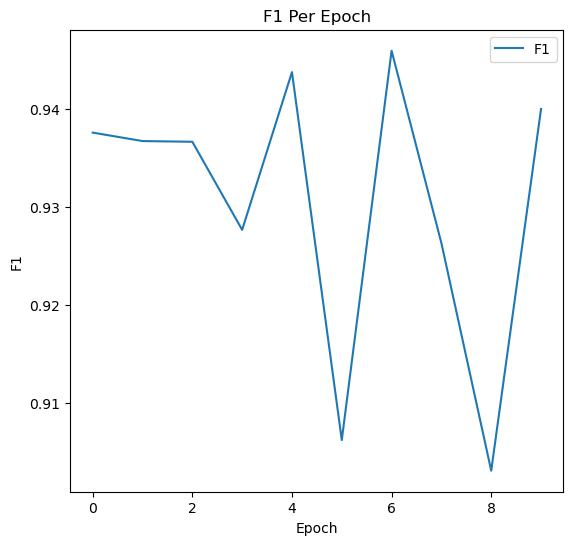

In [13]:
plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
plt.plot(f1, label="F1")
plt.title('F1 Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.legend()

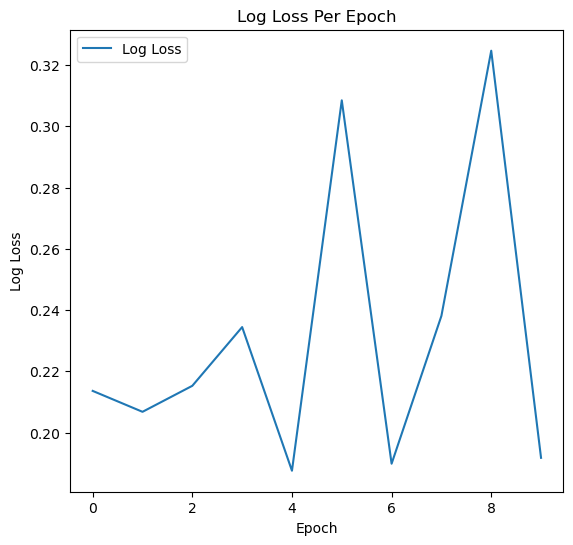

In [14]:
plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
plt.plot(log_loss, label="Log Loss")
plt.title('Log Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.legend()

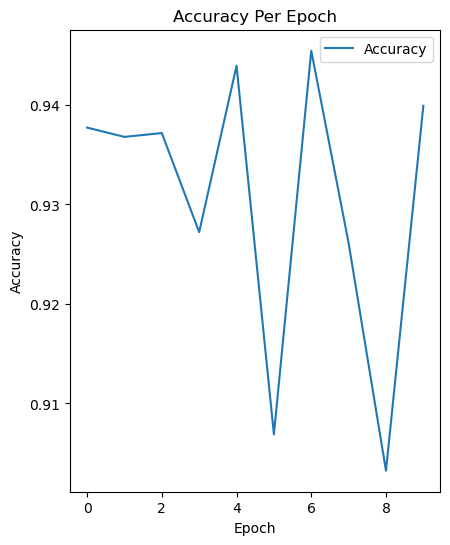

In [18]:
plt.figure(figsize=(10.5,6))
plt.subplot(1, 2, 1)
plt.plot(accuracy, label="Accuracy")
plt.title('Accuracy Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

[[ 936    0    7    0    3    1   19    1   13    0]
 [   0 1106   10    2    1    0    3    3   10    0]
 [   3    0  982    9    4    3   10    6   13    2]
 [   1    0   21  946    0   11    0   11    7   13]
 [   3    2    7    0  895    3   15    1    6   50]
 [   3    2    6   26    1  827    8    2    9    8]
 [   7    3    5    1    2   15  922    0    3    0]
 [   0   12   12    9    2    2    1  959    5   26]
 [   5    5    9    8    6    7   19    6  893   16]
 [   3    2    1    6   18   15    0   11   14  939]]


<Axes: >

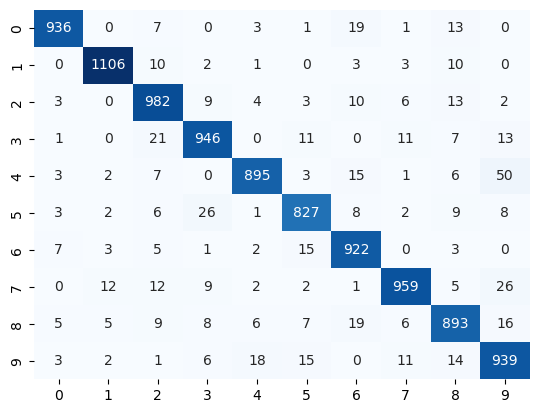

In [16]:
cm = metrics.confusion_matrix(y_test, index)
print(cm)
sns.heatmap(cm, cmap="Blues", cbar=False, annot=True, fmt='d')